In [11]:
import glob
import os 
import string
import requests

import numpy as np
import pandas as pd

from PIL import  Image
import matplotlib.pyplot as plt 

In [3]:
df_emnist = pd.read_csv("./emnist-letters-train.csv", header = None)

In [176]:
def create_etalons(df_emnist, knumber, image_size = 28, space = False):
    emnist_samples = df_emnist.sample(1000).drop_duplicates(0).sort_values(0)[:knumber]
    plt.imshow(emnist_samples.iloc[:knumber, 1:].values.reshape(image_size * knumber, image_size).T)
    # print(emnist_samples[0])
    # emnist_samples[0] = range(knumber)
    etalons_dict = {index : item[1:].reshape(28,28).T for index, item in enumerate(emnist_samples.values)}
    etalons_strings = {list(string.ascii_uppercase)[item - 1] : index for index, item in enumerate(emnist_samples.values[:, 0])}
    etalons_strings_inverse = {index : list(string.ascii_uppercase)[item - 1]for index, item in enumerate(emnist_samples.values[:, 0])}
    if space:
        etalons_dict[knumber] = np.zeros([28, 28])
        etalons_strings_inverse[knumber] = ' '
        etalons_strings[' '] = knumber 
    print(etalons_strings)
    return etalons_dict, etalons_strings, etalons_strings_inverse

In [241]:
def image_stack(list_images): 
    return np.hstack(list_images)

def show_etalons(etalons_dict, write_on = False):
    if write_on: plt.imsave('./etalons.png', image_stack([item[1] for item in sorted(etalons_dict.items())]))
    plt.imshow(concat_images([item[1] for item in sorted(etalons_dict.items())]))
    
def string_convert(text_str, etalons_dict, etalons_strings):
    input_text = list(text_str.upper())
    return image_stack([etalons_dict[etalons_strings[character]] for character in input_text if character in etalons_strings.keys()])

def get_noisy(image, mu, sigma): 
    row, col = image.shape
    gauss = np.random.normal(mu, sigma,(row, col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    return noisy % 255

In [242]:
np.random.randint(0, 100, 20)

array([71, 72, 25, 69,  0, 61, 47, 56,  4, 98, 23, 29, 62,  9, 80, 46, 57,
       19, 51, 12])

In [256]:
def read_sample_text(path, etalons):
    with open(path, 'r') as file:
        text = ''.join([i for i in list(' '.join(file.readlines()).upper()) if i in etalons.keys()])
        diff = set(text).difference(etalons.keys())
        if len(diff) > 0:
            raise Exception(f"Next characters are missing or excess - {diff} .")
        else: return text


def prepare_dataset(sample_text, etalons_dict, etalons_strings, mu = 0, sigma = 10, nsamples = 110, sample_size = 100):
    chunk_size = 25
    chunks = [sample_text[i:i + chunk_size] for i in range(0, len(sample_text), chunk_size)][:-1]
    nchunks = len(chunks)
    dataset = []
    test_dataset = []
    train_dataset = [] 
    for i in range(nsamples):
        y_idx = np.random.randint(0, nchunks, 4)
        y_values = ''.join([chunks[index] for index in y_idx])
        x_values = string_convert(y_values, etalons_dict, etalons_strings)
        x_noised = get_noisy(x_values, mu = mu, sigma = sigma)
        test_dataset.append([y_values, x_noised]) if i < 100 else train_dataset.append([y_values, x_noised])
 
    # chunk_size = 100
    # chunks = [sample_text[i:i + chunk_size] for i in range(0, len(sample_text), chunk_size)][:-1]
    # print(chunks)
    # for j in range(10):
    #     y_train_values = ''.join(chunks[j])
    #     x_train_values = string_convert(y_train_values, etalons_dict, etalons_strings)
    #     x_noised_values = get_noisy(x_train_values, mu = mu, sigma = sigma)
    #     train_dataset.append([y_train_values, x_noised_values])

    return train_dataset, test_dataset

In [257]:
def get_alpha(alpha, k, image_size):
    return alpha[k * image_size: (k + 1) * image_size]

def get_x(X, index, image_size):
    return X[index * image_size: (index + 1) * image_size]

def transform(X):
    return np.ravel(X)

def get_pos(label, image_size):
    return label * image_size, (label + 1) * image_size

def fit(train_df, etalons, image_size, text_size):
    K_ = len(etalons.keys())
    alpha_size = K_ * image_size**2
    
    alpha = np.zeros(alpha_size)
    corrections = 1
    while (corrections > 0):
        corrections = 0
        for index, item in enumerate(train_df):
            labels, x_train = item[0], item[1]
            X_item = transform(x_train)
            for _i in range(text_size):
                # print(_i)
                real_label = etalons[labels[_i]]
                # print(real_label)
                current_x = get_x(X_item, _i, image_size**2)
                alpha_current = get_alpha(alpha, real_label, image_size**2)
                # print(X_item)
                value_ = np.dot(alpha_current, current_x)
                # print(alpha_current.mean())    
                # print(value_)
                for k_j in etalons.values():
                    if k_j == real_label:
                        continue
                    alpha_j = get_alpha(alpha, k_j, image_size**2)
                    value_j = np.dot(alpha_j, current_x)
                    if value_ <= value_j:
                        corrections += 1
                        
                        # pos_start, pos_end = get_pos(real_label, image_size**2)
                        alpha[real_label * image_size**2: (real_label + 1) * image_size**2] += current_x
                        alpha[k_j * image_size**2 : (k_j + 1) * image_size**2] -= current_x 
        print(corrections)
        
    return alpha


In [258]:
def predict(test_df, alpha, etalons, image_size, text_size):
    results = []
    for item in test_df:
        label, x_test = item[0], item[1]
        predicted_label = []
        for _i in range(text_size):
                X_item = transform(x_test)
                current_x = get_x(X_item, _i, image_size**2)
                values = np.zeros(len(etalons.keys()))
                for k in etalons.keys():
                    alpha_current = get_alpha(alpha, etalons[k], image_size**2)
                    values[etalons[k]] = np.dot(alpha_current, current_x)
                # print(np.argmax(values))
                predicted_label.append(np.argmax(values))
        results.append((pd.concat([pd.Series(list(label)),pd.Series(predicted_label).astype(int)], axis = 1)))
        # results.append((pd.concat([pd.Series(list(label)).apply(lambda x : etalons_strings[x]),pd.Series(predicted_label).astype(int)], axis = 1)))
    return results

In [259]:
def plot_results(test_df, predicted, _inverse_dict, etalons_dict, etalons_strings,):
    predicted_ = predicted[1].apply(lambda x : _inverse_dict[x])
    result = np.zeros((28,28 * 100))
    for i in range(len(test_df)):
        corrupted_image = test_df[i][1]
        clear_predicted = string_convert(''.join(predicted_[i:(i+1) * 100]), etalons_dict, etalons_strings)[:, -2800:]
        result = np.vstack([result, np.vstack([corrupted_image, clear_predicted])])
    return result

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, ' ': 26}


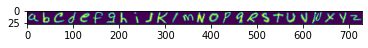

In [301]:
etalons_dict, etalons_strings, etalons_strings_inv = create_etalons(df_emnist, 26, 28, True)

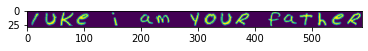

In [302]:
test = "Luke I am your Father"
test_image = string_convert(test, etalons_dict, etalons_strings)
plt.imshow((test_image))

In [303]:
input_text = read_sample_text('/home/vmalyniak/home/jupyter/pattern/Pattern_Rec2021/lab_5/dada_text.txt', etalons_strings)
train_df, test_df = prepare_dataset(input_text, etalons_dict, etalons_strings, mu = 1,  sigma = 10)
alpha1 = fit(train_df, etalons_strings, 28, 100)

9006
1480
334
86
70
34
42
16
15
10
5
3
1
0


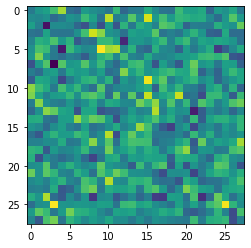

In [304]:
max_element = np.linalg.norm(alpha1, np.inf)
alpha = alpha1 / max_element * 255
alpha = (alpha + 255) / 2

plt.imshow(get_alpha(alpha, 0, 28 * 28).reshape(28, 28))

In [305]:
from sklearn.metrics import accuracy_score

predicted = pd.concat(predict(test_df, alpha1, etalons_strings, 28, 100))
accuracy_score(predicted[1], predicted[0].apply(lambda x : etalons_strings[x]))

0.1002

In [306]:
result = plot_results(test_df, predicted, etalons_strings_inv,etalons_dict, etalons_strings)

In [307]:
plt.imsave('/home/vmalyniak/home/jupyter/pattern/Pattern_Rec2021/lab_5/result.jpg', result)